In [167]:
from osgeo import gdal, osr
import pandas as pd
import geopandas as gpd
import os
from scipy.optimize import curve_fit
import seaborn as sns
import multiprocessing as mp
import psutil
from scipy import stats
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

* NDVI and NIR product: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD13A1 (16 days).
* LAI product: https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD15A2H (8 days).

In [168]:
def read_tif(tif_file):
    dataset = gdal.Open(tif_file)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    im_proj = (dataset.GetProjection())
    im_Geotrans = (dataset.GetGeoTransform())
    im_data = dataset.ReadAsArray(0, 0, cols, rows)
    if im_data.ndim == 3:
        im_data = np.moveaxis(dataset.ReadAsArray(0, 0, cols, rows), 0, -1)
    return im_data, im_Geotrans, im_proj,rows, cols
def array_to_geotiff(array, output_path, geo_transform, projection, band_names=None):
    rows, cols, num_bands = array.shape
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(output_path, cols, rows, num_bands, gdal.GDT_Float32)
    
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    for band_num in range(num_bands):
        band = dataset.GetRasterBand(band_num + 1)
        band.WriteArray(array[:, :, band_num])
        band.FlushCache()
        
        if band_names:
            band.SetDescription(band_names[band_num])
    
    dataset = None
    band = None
def raster_to_points(geotiff, shp_name):
    inDs = gdal.Open(geotiff)
    DsoutDs = gdal.Translate(f"{shp_name}.xyz", inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
    outDs = None
    try:
        os.remove(f'{shp_name}.csv')
    except OSError:
        pass

    os.rename(f'{shp_name}.xyz', f'{shp_name}.csv')
    os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(shp_name))
    try:
        os.remove(f'{shp_name}.csv')
    except OSError:
        pass
    crs_wkt = inDs.GetProjection()
    shp_layer = gpd.read_file(f"{shp_name}.shp")
    shp_layer.crs = crs_wkt
    shp_layer.to_file(f"{shp_name}.shp")
    return

def filter_points(shp_path, file_name, min_distance):
    points = gpd.read_file(f'{shp_path}/{file_name}')
    points.drop(columns=['Z'],inplace = True)
    gdf_copy = points.copy()
    to_remove = []

    for index, row in gdf_copy.iterrows():
        if index not in to_remove:
            distances = gdf_copy.geometry.distance(row.geometry)
            close_points = distances[distances < min_distance].index.tolist()
            close_points.remove(index)
            to_remove.extend(close_points)

    gdf_copy.drop(index=to_remove, inplace=True)
    gdf_copy.reset_index(drop = True, inplace = True)
    gdf_copy.to_file(f'{shp_path}/{file_name[:-4]}_filtered.shp')
    return

### 1. rename files

In [4]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/1_MODIS_monthly_VI_LAI/"
folders = ["1_MODIS_monthly_LAI", "2_MODIS_monthly_NDVI", "3_MODIS_monthly_NIR"]
original_names = [f"{x}.tif" for x in np.arange(0,48)]

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]

names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}"
        names.append(dates)

lai_names = [f"{x}_lai.tif" for x in names]
ndvi_names = [f"{x}_ndvi.tif" for x in names]
nir_names = [f"{x}_nir.tif" for x in names]
# target_names = [lai_names, ndvi_names,nir_names]
target_names = [nir_names]

k = 0
for folder in folders:
    path = f"{data_path}{folder}"
    source_names = original_names
    desti_names = target_names[k]
    for i in range(len(source_names)):
        source_file = f"{path}/{source_names[i]}"
        desti_file = f"{path}/{desti_names[i]}"
        os.rename(source_file, desti_file)
    k = k+1

### 2. merge NDVI and LAI data

In [9]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/1_MODIS_monthly_VI_LAI/"
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/2_Merged_VI_LAI/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]

names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}"
        names.append(dates)

lai_names = [f"{x}_lai.tif" for x in names]
ndvi_names = [f"{x}_ndvi.tif" for x in names]
nir_names = [f"{x}_nir.tif" for x in names]

for i in range(len(lai_names)):
    ndvi_data = f"{data_path}2_MODIS_monthly_NDVI/{ndvi_names[i]}"
    lai_data = f"{data_path}1_MODIS_monthly_LAI/{lai_names[i]}"
    nir_data = f"{data_path}3_MODIS_monthly_NIR/{nir_names[i]}"
    
    im_data1, im_Geotrans, im_proj,rows, cols = read_tif(ndvi_data)
    im_data2, im_Geotrans, im_proj,rows, cols = read_tif(lai_data)
    im_data3, im_Geotrans, im_proj,rows, cols = read_tif(nir_data)
    data_array = np.stack([im_data1, im_data2, im_data3], axis = -1)
    
    out_tif = f"{out_path}{lai_names[i][:-8]}.tif"
    array_to_geotiff(data_array, out_tif, im_Geotrans, im_proj, band_names=["NDVI", "LAI","NIR"])
   

### 3. clip the merged data to NEON extend

In [ ]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/2_Merged_VI_LAI/"
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/3_Clipped_to_NEON_extent/"
prisma_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/2_PRISMA_L2D/2_PRISMA_L2D_tif_2020_2023/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.tif"
        names.append(dates)
for site in site_list:
    print(site)
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    path = f"{prisma_path}{site}"
    file_list = os.listdir(path)
    file_list = [x for x in file_list if "LATLON.tif" in x]
    ul_x_all,lr_y_all, lr_x_all, ul_y_all = [],[],[],[]
    for file in file_list:
        im_data, im_Geotrans, im_proj,rows, cols = read_tif(f"{path}/{file}")
        ul_x, lr_y, lr_x, ul_y = im_data[0,0,1],im_data[-1,-1,0],im_data[-1,-1,1],im_data[0,0,0]
        ul_x_all.append(ul_x)
        lr_y_all.append(lr_y)
        lr_x_all.append(lr_x)
        ul_y_all.append(ul_y)
    ul_x, lr_y, lr_x, ul_y = min(ul_x_all),min(lr_y_all), max(lr_x_all), max(ul_y_all)
    ul_x, lr_y, lr_x, ul_y = ul_x-0.01, lr_y-0.01, lr_x+0.01, ul_y+0.01
    print(site, ul_x, lr_y, lr_x, ul_y)
    
    output_path = f"{out_path}/{site}"
    for file in names:
        input_tif = f"{data_path}{file}"
        output_tif =f"{output_path}/{file}"
        
        gdal.Warp(output_tif, input_tif, format = 'GTiff', outputBounds=(ul_x, lr_y, lr_x, ul_y))
        input_tif = None
        output_tif = None

### 4. process lulc data

In [ ]:
lulc_path = "/Volumes/ChenLab-1/Fujiang/0_PhD_dissertation_data/3_GLC_FCS30D_Land_cover_data_US/4_land_cover_NEON_sites/"
prisma_path = "/Volumes/ChenLab-1/Fujiang/0_PhD_dissertation_data/2_PRISMA_L2D/2_PRISMA_L2D_tif_2020_2023/"
out_path = "/Volumes/ChenLab-1/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/4_Process_LULC_data/"

site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']

years = [2020,2021,2022]
for site in site_list:
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    path = f"{prisma_path}{site}"
    file_list = os.listdir(path)
    file_list = [x for x in file_list if "LATLON.tif" in x]
    ul_x_all,lr_y_all, lr_x_all, ul_y_all = [],[],[],[]
    for file in file_list:
        im_data, im_Geotrans, im_proj,rows, cols = read_tif(f"{path}/{file}")
        ul_x, lr_y, lr_x, ul_y = im_data[0,0,1],im_data[-1,-1,0],im_data[-1,-1,1],im_data[0,0,0]
        ul_x_all.append(ul_x)
        lr_y_all.append(lr_y)
        lr_x_all.append(lr_x)
        ul_y_all.append(ul_y)
    ul_x, lr_y, lr_x, ul_y = min(ul_x_all),min(lr_y_all), max(lr_x_all), max(ul_y_all)
    ul_x, lr_y, lr_x, ul_y = ul_x-0.01, lr_y-0.01, lr_x+0.01, ul_y+0.01
    print(site, ul_x, lr_y, lr_x, ul_y)
    
    lulc_files = [f"{site}_{x}_land_cover.tif" for x in years]
    output_path = f"{out_path}/{site}"
    for file in lulc_files:
        input_file = f"{lulc_path}{site}/{file}"
        output_file = f"{output_path}/{file}"
        dataset = gdal.Open(input_file)
        gdal.Warp(output_file, dataset, dstSRS='EPSG:4326')
        dataset = None

        input_tif = f"{output_path}/{file}"
        output_tif =f"{output_path}/{file}"
        
        gdal.Warp(output_tif, input_tif, format = 'GTiff', outputBounds=(ul_x, lr_y, lr_x, ul_y))
        input_tif = None
        output_tif = None

### 5. merge lulc data with MODIS LAI and NDVI data

In [50]:
### This script need to be ran at QGIS Python Console.
modis_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/3_Clipped_to_NEON_extent/"
lulc_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/4_Process_LULC_data/"
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/5_Merged_lulc_modis/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.tif"
        names.append(dates)

for site in site_list:
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    modis_file_path = f"{modis_path}{site}"
    lulc_file_path = f"{lulc_path}{site}"
    output_path = f"{out_path}{site}"
    for file in names:
        modis_file = f"{modis_file_path}/{file}"
        yr = file[0:4]
        if yr == "2023":
            yr ="2022"
        lulc_file = f"{lulc_file_path}/{site}_{yr}_land_cover.tif"
        
        data_merged = [lulc_file,modis_file]
        export_data = f"{output_path}/{file}"
        processing.run("gdal:merge", {'INPUT':data_merged,'PCT':False,'SEPARATE':True,'NODATA_INPUT':None,'NODATA_OUTPUT':None,
                                      'OPTIONS':'','EXTRA':'','DATA_TYPE':5,'OUTPUT':export_data})

### 6. filter MODIS VI and LAI according to lulc.

In [3]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/5_Merged_lulc_modis/"
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/6_Filter_data/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.tif"
        names.append(dates)

for site in site_list:
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    path = f"{data_path}{site}"
    output_path = f"{out_path}{site}"
    
    for file in names:
        print(site, file)
        im_data, im_Geotrans, im_proj,rows, cols = read_tif(f"{path}/{file}")
        lulc = im_data[:,:,0]
        ndvi = im_data[:,:,1]*0.0001
        lai = im_data[:,:,2]*0.1
        nir = im_data[:,:,3]*0.0001
        nirv = ndvi*nir
        
        
        excluded_value = [140, 181, 182, 183, 184,185,186,187,190,200,201,202,210,220,0,250]
        mask = ~np.isin(lulc, excluded_value)
        
        radius = 8
        y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
        structure = x**2 + y**2 <= radius**2
        mask = ~binary_dilation(~mask, structure=structure)
        
        ndvi = np.where(mask, ndvi, np.nan)
        lai = np.where(mask, lai, np.nan)
        nirv = np.where(mask, nirv, np.nan)
        out_image = np.stack([ndvi,nirv,lai], axis = -1)
        out_tif = f"{output_path}/{file}"
        array_to_geotiff(out_image, out_tif, im_Geotrans, im_proj, band_names=["NDVI", "NIRv", "LAI"])        

D01_BART 2020-01.tif
D01_BART 2020-02.tif
D01_BART 2020-03.tif
D01_BART 2020-04.tif
D01_BART 2020-05.tif
D01_BART 2020-06.tif
D01_BART 2020-07.tif
D01_BART 2020-08.tif
D01_BART 2020-09.tif
D01_BART 2020-10.tif
D01_BART 2020-11.tif
D01_BART 2020-12.tif
D01_BART 2021-01.tif
D01_BART 2021-02.tif
D01_BART 2021-03.tif
D01_BART 2021-04.tif
D01_BART 2021-05.tif
D01_BART 2021-06.tif
D01_BART 2021-07.tif
D01_BART 2021-08.tif
D01_BART 2021-09.tif
D01_BART 2021-10.tif
D01_BART 2021-11.tif
D01_BART 2021-12.tif
D01_BART 2022-01.tif
D01_BART 2022-02.tif
D01_BART 2022-03.tif
D01_BART 2022-04.tif
D01_BART 2022-05.tif
D01_BART 2022-06.tif
D01_BART 2022-07.tif
D01_BART 2022-08.tif
D01_BART 2022-09.tif
D01_BART 2022-10.tif
D01_BART 2022-11.tif
D01_BART 2022-12.tif
D01_BART 2023-01.tif
D01_BART 2023-02.tif
D01_BART 2023-03.tif
D01_BART 2023-04.tif
D01_BART 2023-05.tif
D01_BART 2023-06.tif
D01_BART 2023-07.tif
D01_BART 2023-08.tif
D01_BART 2023-09.tif
D01_BART 2023-10.tif
D01_BART 2023-11.tif
D01_BART 2023

### 7. extract training data points

In [ ]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/3_Clipped_to_NEON_extent/"  # use this 500m pixels data, because the previous steps data increased the size of image due to merging with higher resolution LULC data. Use this data to get points and then extract the data values from the previous step data. 
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/7_extracted_points/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.tif"
        names.append(dates)
for site in site_list:
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    path = f"{data_path}{site}"
    output_path = f"{out_path}{site}"
    for file in names:
        raster_to_points(f"{path}/{file}", f"{output_path}/{file[:-4]}")   

### 8. process extracted points

In [ ]:
data_path = "/Volumes/ChenLab-1/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/7_extracted_points/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.shp"
        names.append(dates)

for site in site_list:
    path = f"{data_path}{site}"
    for file in names:
        print(site, file)
        filter_points(path, file, 0.009)

### 9. Extract VI and NDVI to points

In [ ]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/7_extracted_points/"
imagery_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/6_Filter_data/"
lulc_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/4_Process_LULC_data/"
out_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"


land_cover_type = {10: "Rainfed cropland",11: "Herbaceous cover cropland",12: "Tree or shrub cover (Orchard) cropland",
                   20: "Irrigated cropland",51: "Open evergreen broadleaved forest",52: "Closed evergreen broadleaved forest",
                   61: "Open deciduous broadleaved forest",62: "Closed deciduous broadleaved forest",71: "Open evergreen needle-leaved forest",
                   72: "Closed evergreen needle-leaved forest",81: "Open deciduous needle-leaved forest",82: "Closed deciduous needle-leaved forest",
                   91: "Open mixed leaf forest (broadleaved and needle-leaved)",92: "Closed mixed leaf forest (broadleaved and needle-leaved)", 
                   120: "Shrubland",121: "Evergreen shrubland",122: "Deciduous shrubland",130: "Grassland",140: "Lichens and mosses",
                   150: "Sparse vegetation",152: "Sparse shrubland",153: "Sparse herbaceous",181: "Swamp",182: "Marsh",183: "Flooded flat",
                   184: "Saline",185: "Mangrove",186: "Salt marsh",187: "Tidal flat",190: "Impervious surfaces",200: "Bare areas",
                   201: "Consolidated bare areas",202: "Unconsolidated bare areas",210: "Water body",220: "Permanent ice and snow",
                   0: "Filled value",250: "Filled value"}

PFTs = {'Open deciduous needle-leaved forest':"DNF", 'Closed deciduous broadleaved forest':"DBF",'Closed evergreen needle-leaved forest':"ENF",
        'Open evergreen broadleaved forest':"EBF",'Herbaceous cover cropland':"CPR", 'Open deciduous broadleaved forest':"DBF",
        'Closed deciduous needle-leaved forest':"DNF", 'Shrubland':"SHR", 'Open evergreen needle-leaved forest':"ENF", 'Grassland':"GRA", 
        'Rainfed cropland':"CPR", 'Irrigated cropland':"CPR", 'Open mixed leaf forest (broadleaved and needle-leaved)':"MF",'Evergreen shrubland':"SHR", 
        'Closed evergreen broadleaved forest':"EBF", 'Sparse herbaceous':"GRA", 'Deciduous shrubland':"SHR", 'Sparse shrubland':"SHR"}


years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}_filtered.shp"
        names.append(dates)

for site in site_list:
    print(site)
    os.makedirs(f"{out_path}/{site}", exist_ok=True)
    shp_path = f"{data_path}{site}"
    tif_path = f"{imagery_path}{site}"
    lulc_image_path = f"{lulc_path}{site}"
    output_path = f"{out_path}{site}"
    
    for file in names:
        points = gpd.read_file(f"{shp_path}/{file}")
        points.drop(columns=['FID'],inplace = True)
        
        tiff_ds = gdal.Open(f"{tif_path}/{file[:7]}.tif")
        num_bands = tiff_ds.RasterCount
        extracted_values = [[] for _ in range(num_bands)]
        for index, row in points.iterrows():
            point = row.geometry
            x, y = point.x, point.y
            
            # Convert point coordinates to pixel coordinates
            px = int((x - tiff_ds.GetGeoTransform()[0]) / tiff_ds.GetGeoTransform()[1])
            py = int((y - tiff_ds.GetGeoTransform()[3]) / tiff_ds.GetGeoTransform()[5])
            
            # Read values from GeoTIFF for each band
            for band_num in range(1, num_bands + 1):
                band = tiff_ds.GetRasterBand(band_num)
                value = band.ReadAsArray(px, py, 1, 1)[0][0]
                extracted_values[band_num - 1].append(value)
        
        extracted_values = pd.DataFrame(np.array(extracted_values)).T
        extracted_values.columns = ["NDVI", "NIRv", "LAI"]
        
        #lulc
        date = file.split("_")[0][:4]
        if date == "2023":
            year = "2022"
        else:
            year = date
            
        landuse_data = f"{lulc_image_path}/{site}_{year}_land_cover.tif"
        land_ds = gdal.Open(landuse_data)
        land_ds_band = land_ds.GetRasterBand(1)
        
        land_values = []
        for index, row in points.iterrows():
            point = row.geometry
            x, y = point.x, point.y
            px_land = int((x - land_ds.GetGeoTransform()[0]) / land_ds.GetGeoTransform()[1])
            py_land = int((y - land_ds.GetGeoTransform()[3]) / land_ds.GetGeoTransform()[5])
            
         
            value_land = land_ds_band.ReadAsArray(px_land, py_land, 1, 1)[0][0]
            land_values.append(value_land)
            

        land_values = [land_cover_type[x] for x in land_values]
        pft = [PFTs[x] if x in PFTs.keys() else np.nan for x in land_values]
        extracted_values["PFT"] = pft
        
        extracted_values.dropna(inplace= True)
        extracted_values = extracted_values[(extracted_values["NDVI"]>0)&(extracted_values["NIRv"]>0)&(extracted_values["LAI"]>0)]
        extracted_values.reset_index(drop = True, inplace = True)
        extracted_values.to_csv(f"{output_path}/{file[:7]}.csv", index = False)

In [42]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"

years = ["2020","2021","2022","2023"]
months =["01",  "02",  "03",  "04",  "05",  "06",  "07",  "08",  "09", "10", "11", "12"]
site_list = ['D01_BART','D01_HARV','D02_SCBI','D03_OSBS','D07_MLBS','D07_ORNL','D08_TALL',
             'D10_CPER','D13_MOAB','D14_JORN','D14_SRER','D16_WREF','D19_BONA','D19_HEAL']
names = []
for yrs in years:
    for mon in months:
        dates = f"{yrs}-{mon}.csv"
        names.append(dates)

start_var = True
for site in site_list:
    path = f"{data_path}{site}"
    for file in names:
        df = pd.read_csv(f"{path}/{file}")
        df["site"] = site[-4:]
        df["year"] = file.split("-")[0]
        df["month"] = file.split("-")[1].split(".")[0]
        if start_var:
            all_df = df
            start_var = False
        else:
            all_df = pd.concat([all_df, df], axis = 0)
all_df["month"] = all_df["month"].astype(str)
all_df.reset_index(drop =True, inplace = True)
all_df.to_csv(f"{data_path}0_all_data_points_NDVI_NIRv_LAI.csv", index = False)

In [162]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"
df = pd.read_csv(f"{data_path}0_all_data_points_NDVI_NIRv_LAI.csv")
df["month"] = df["month"].apply(lambda x: f"{int(x):02d}")

start_var = True
for site in df["site"].unique():
    temp = df[df["site"] == site]
    if site == "BONA":
        temp = temp[~temp['month'].isin(["01", "02","03", "11", "12"])]
    elif site == "HEAL":
        temp = temp[~temp['month'].isin(["01", "02"])]
    
    if start_var:
        all_df = temp
        start_var = False
    else:
        all_df = pd.concat([all_df, temp], axis = 0)

all_df.reset_index(drop =True, inplace = True)
all_df.to_csv(f"{data_path}1_data_points_NDVI_NIRv_LAI.csv", index = False)

### 10. train the site- and PFT-specific LAI models

In [169]:
def rsquared(x, y): 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 
    a = r_value**2
    return a

def r2(y, y_pred):
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def exponential_model(x, a, b):
    return a * np.exp(b * x)

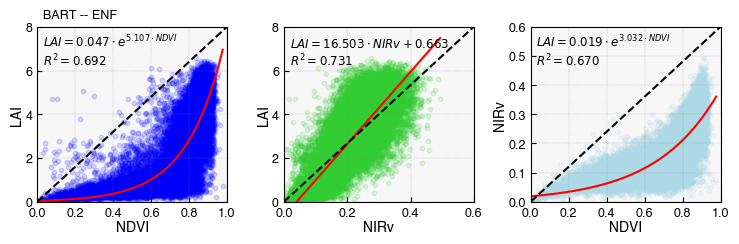

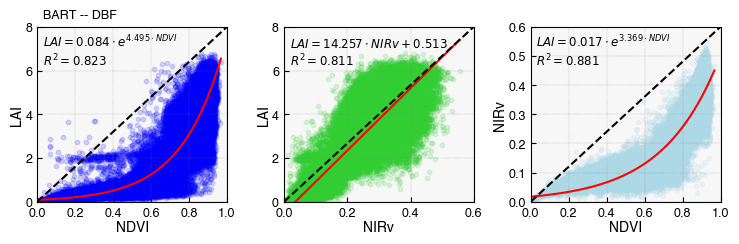

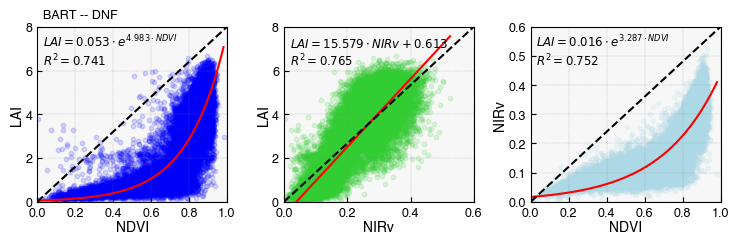

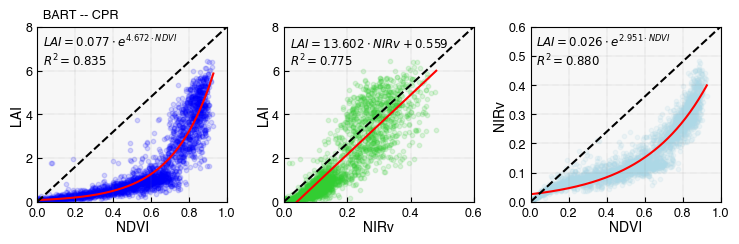

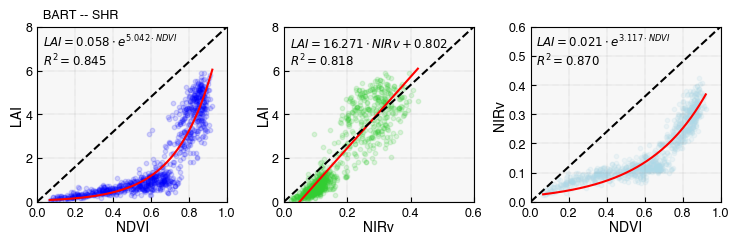

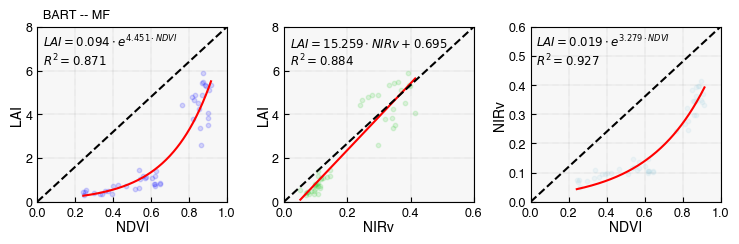

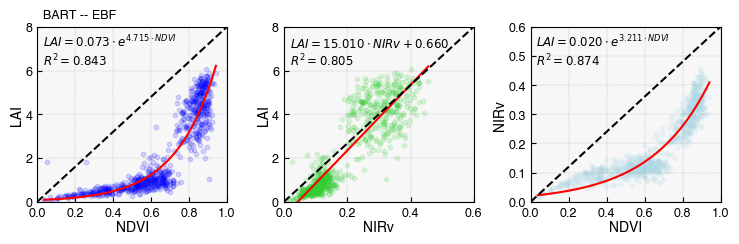

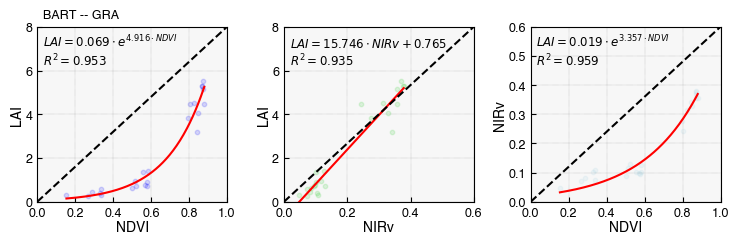

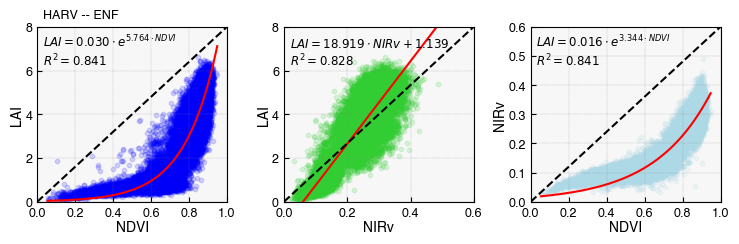

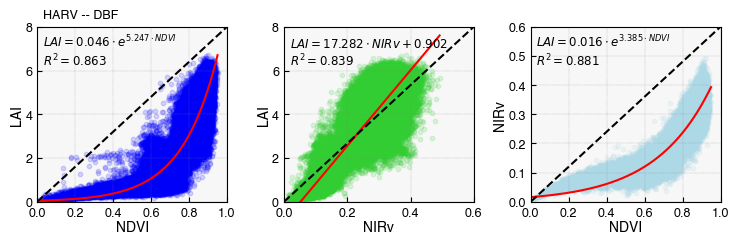

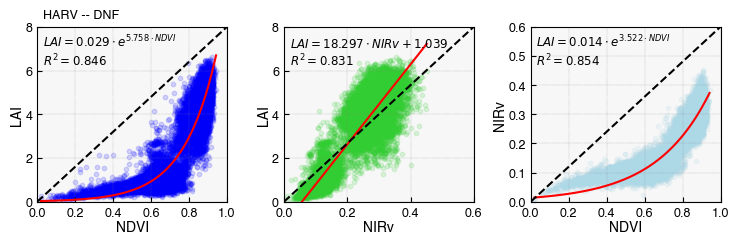

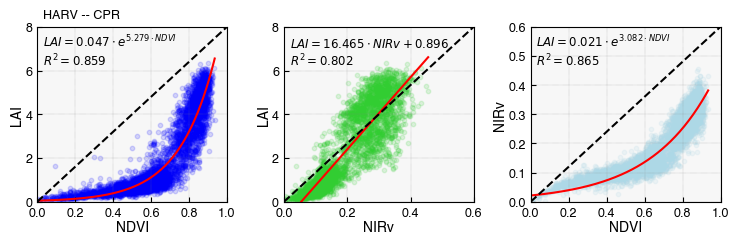

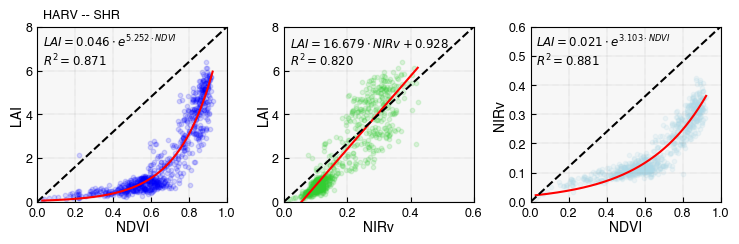

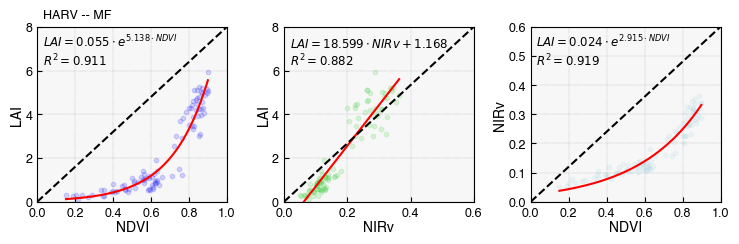

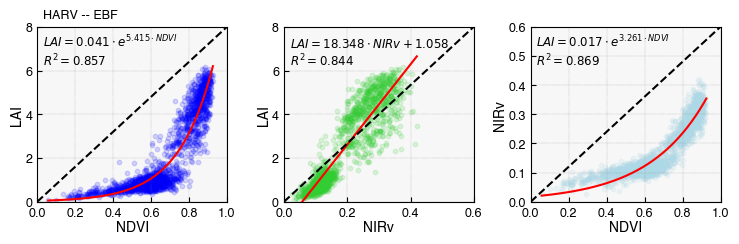

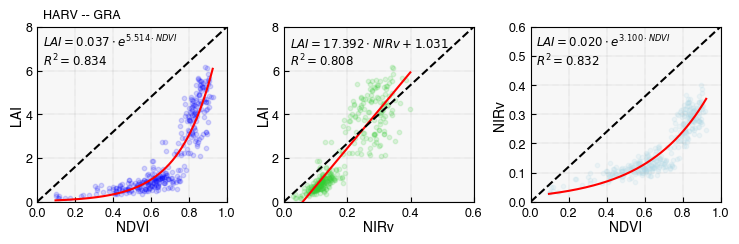

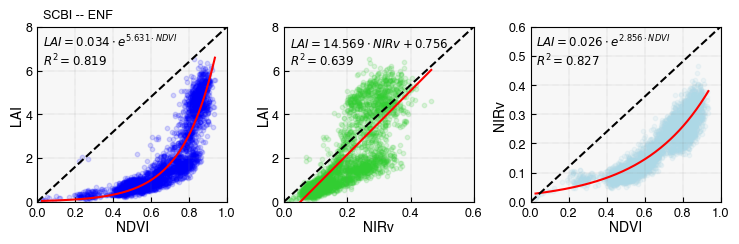

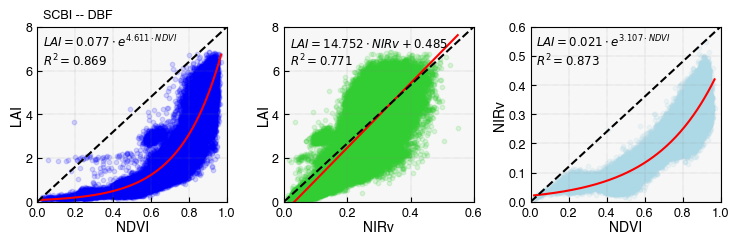

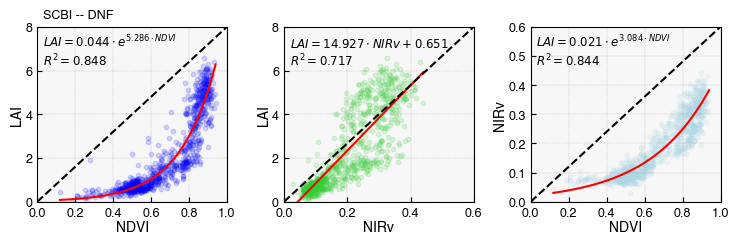

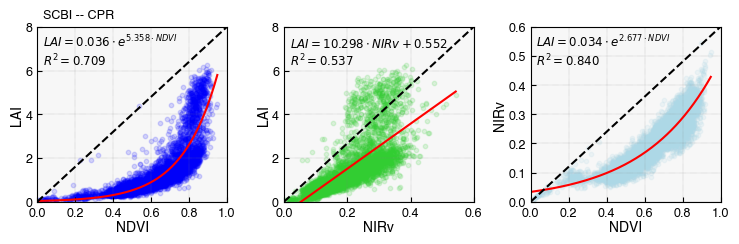

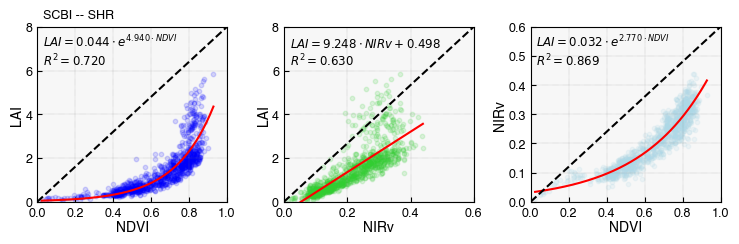

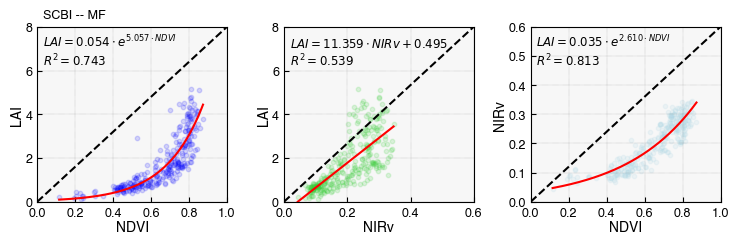

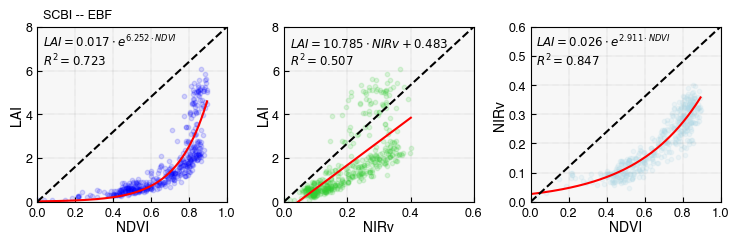

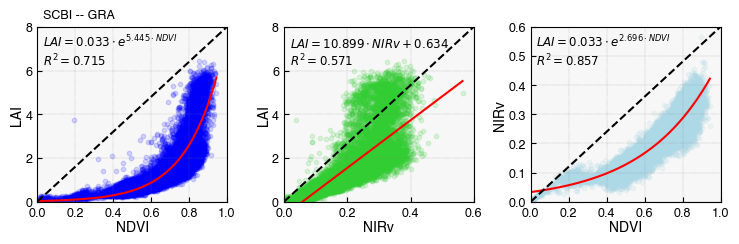

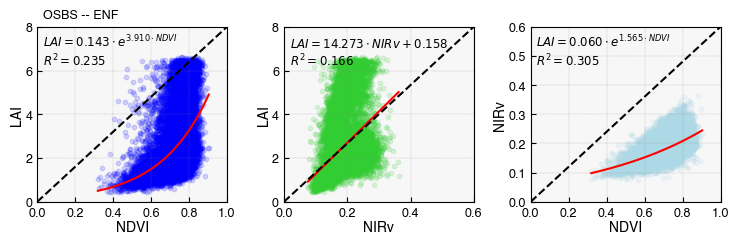

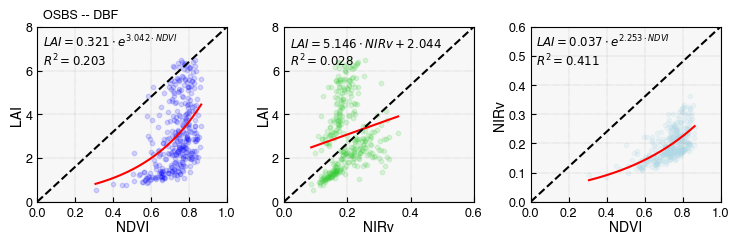

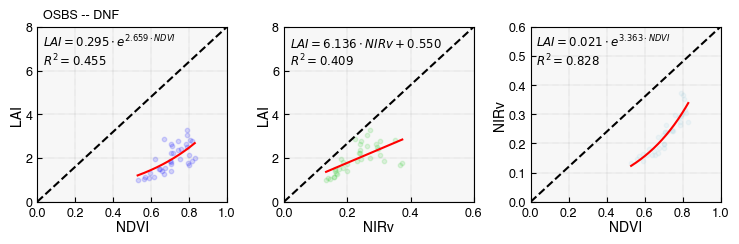

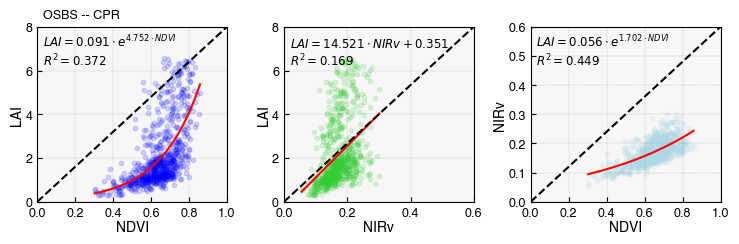

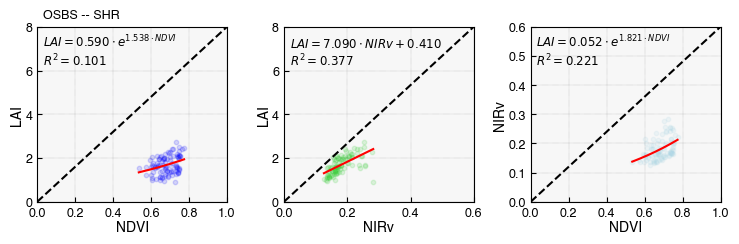

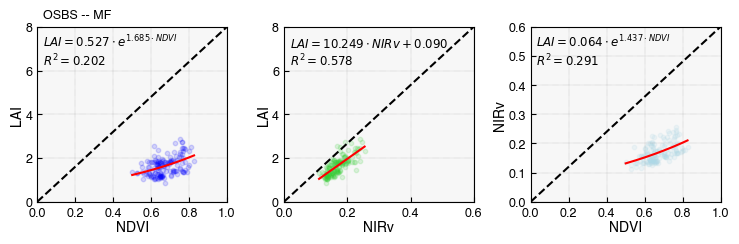

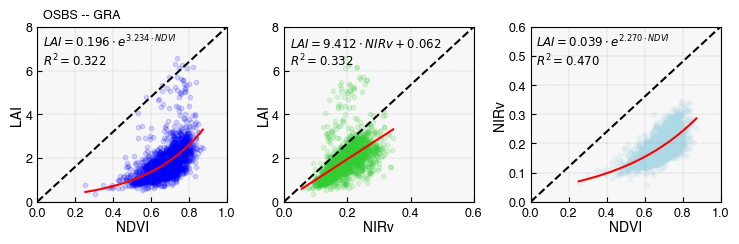

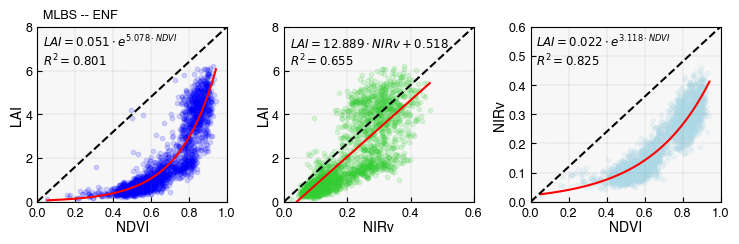

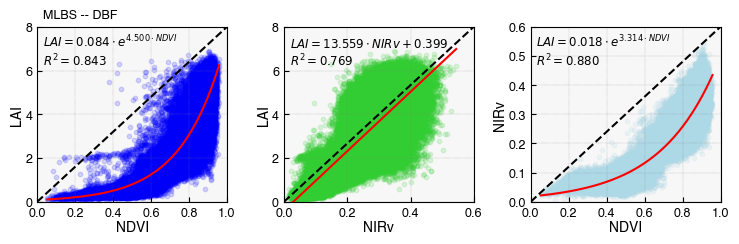

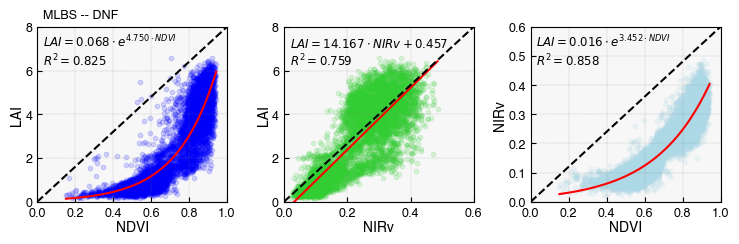

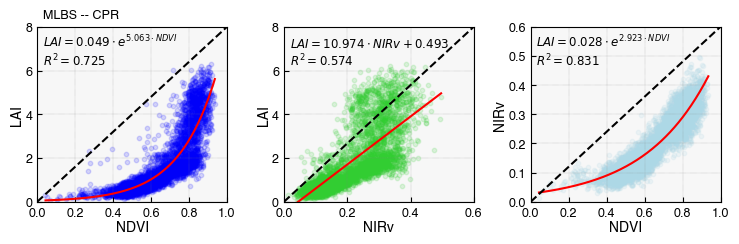

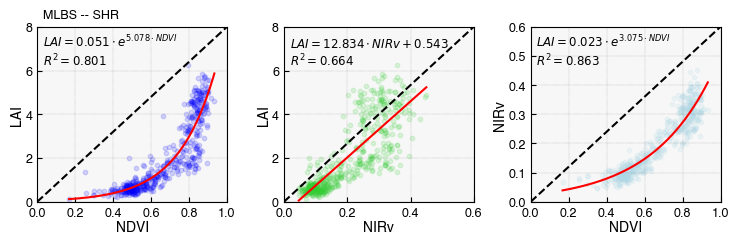

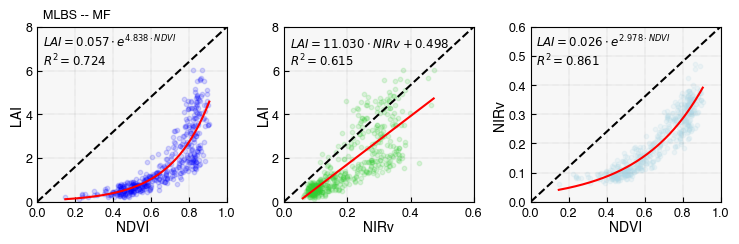

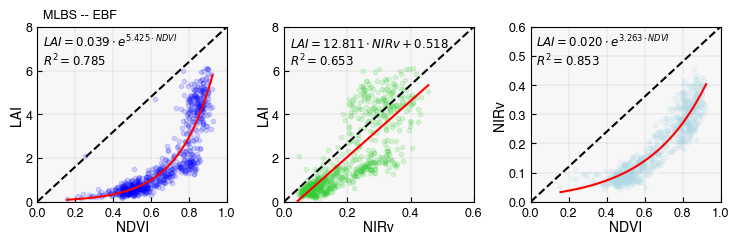

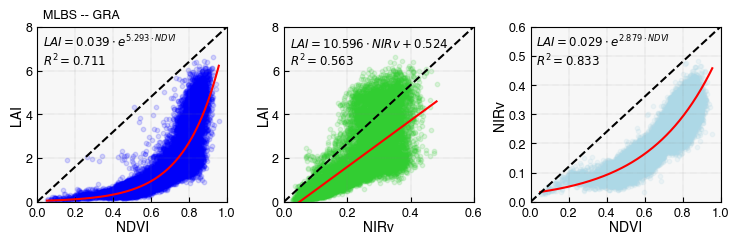

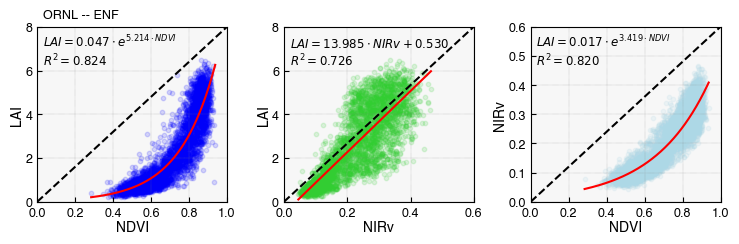

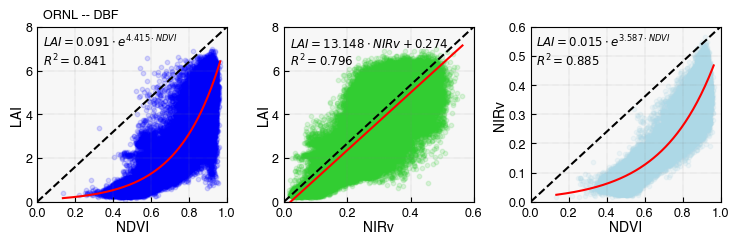

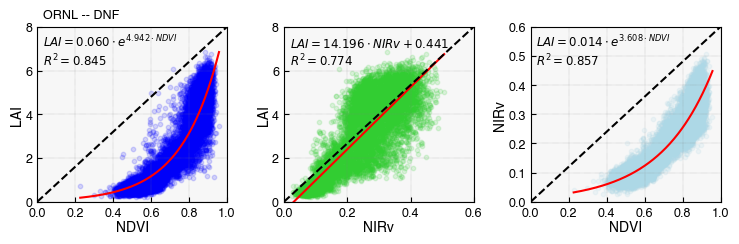

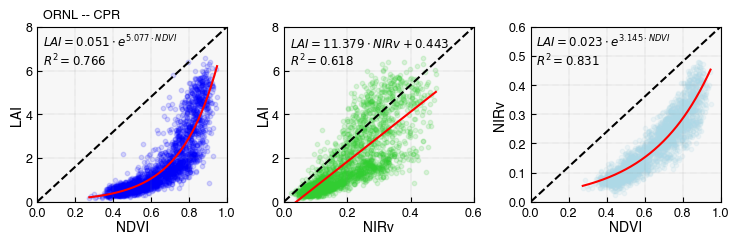

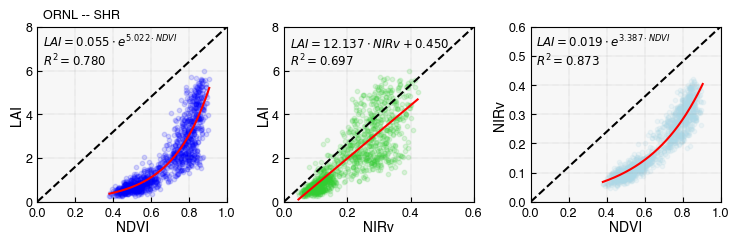

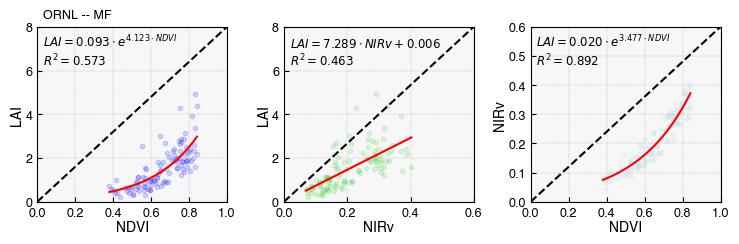

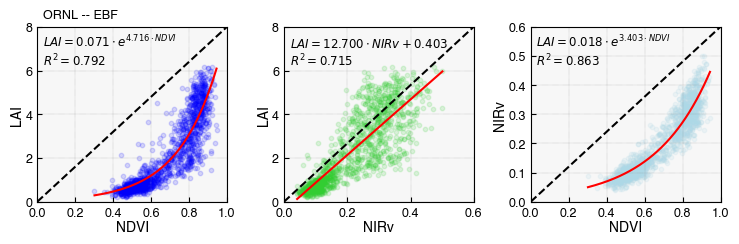

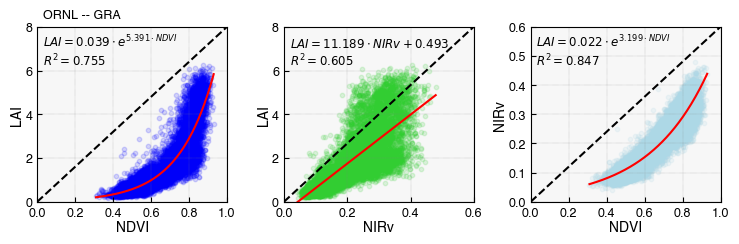

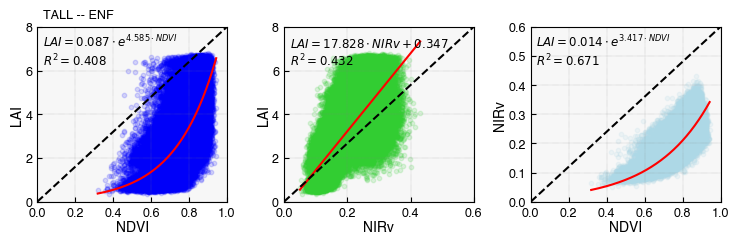

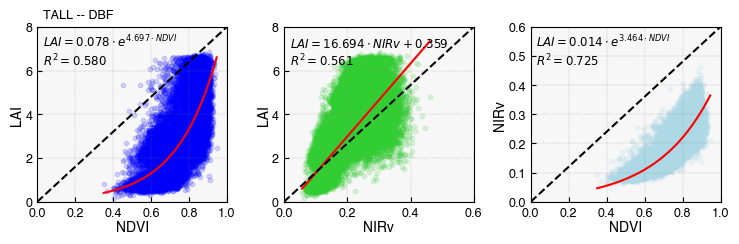

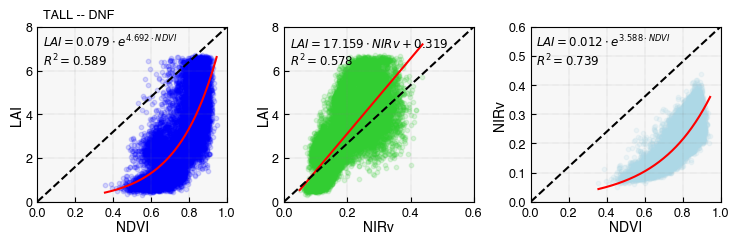

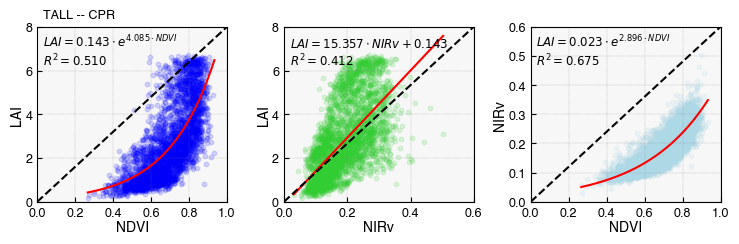

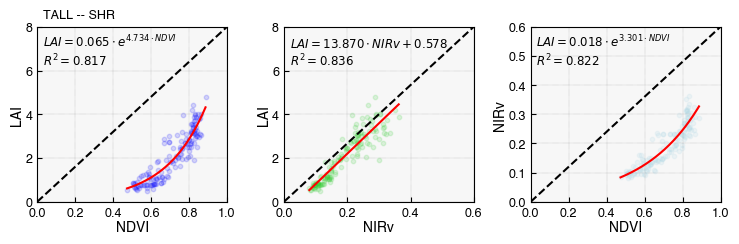

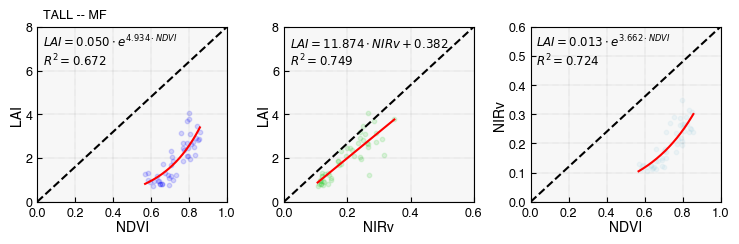

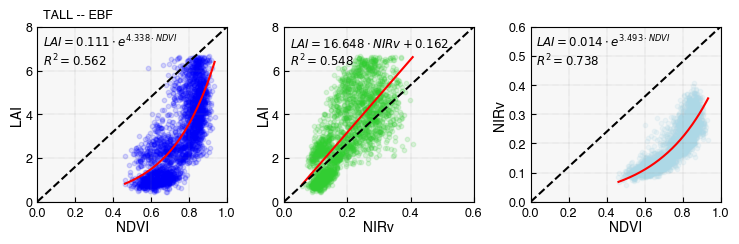

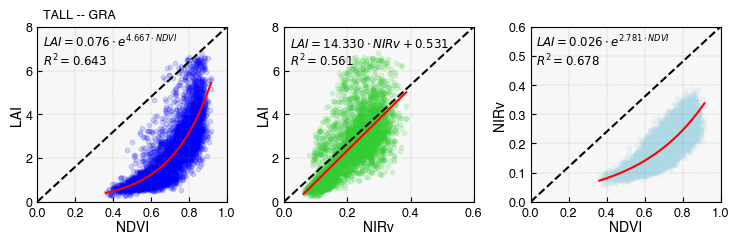

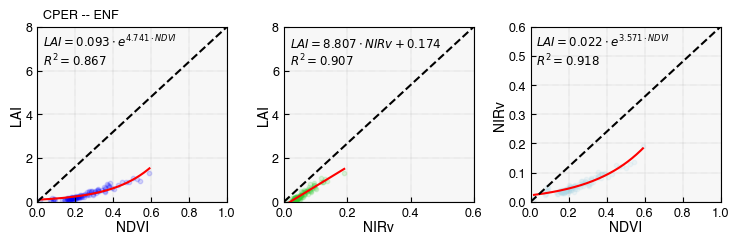

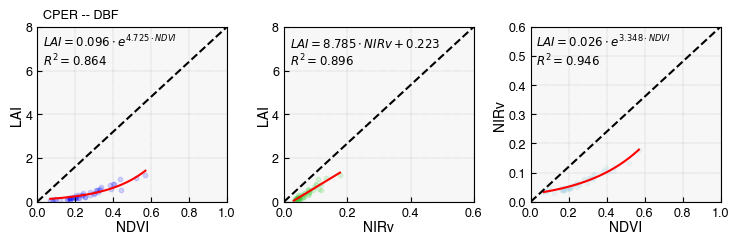

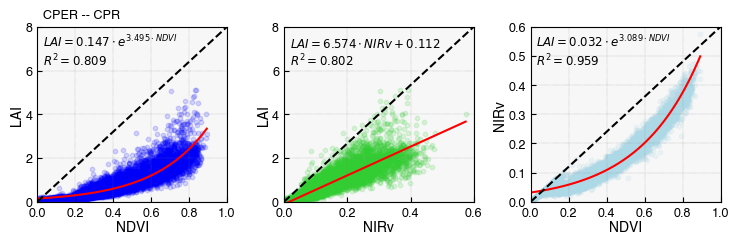

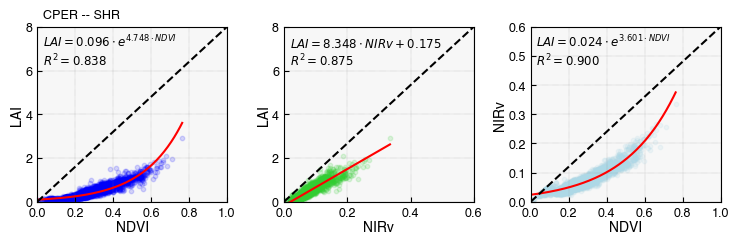

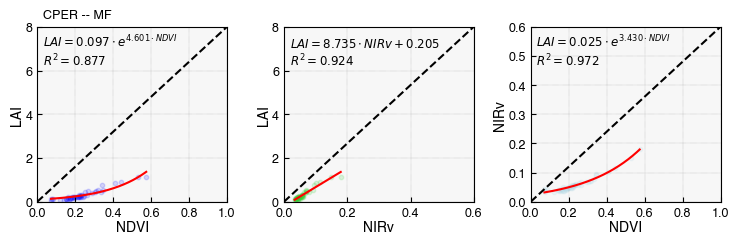

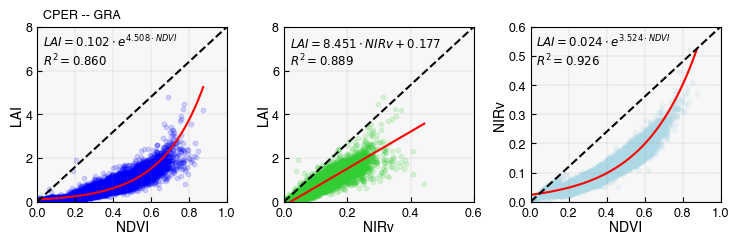

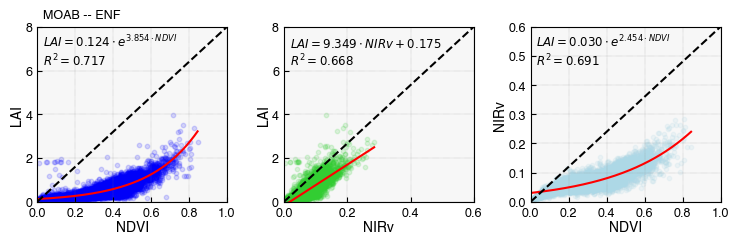

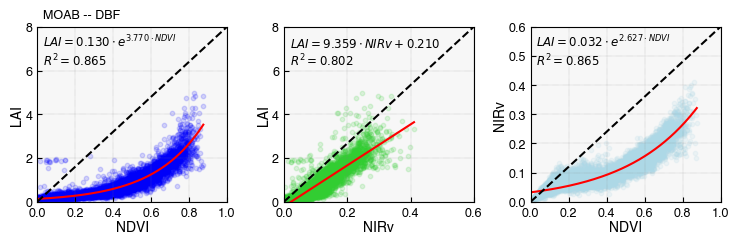

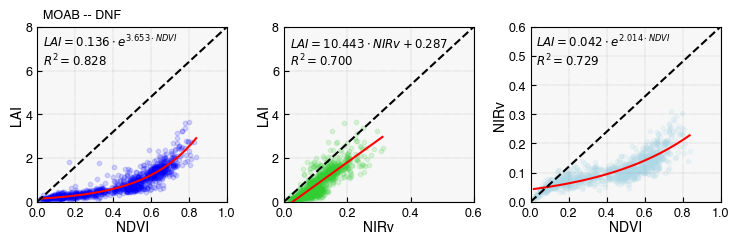

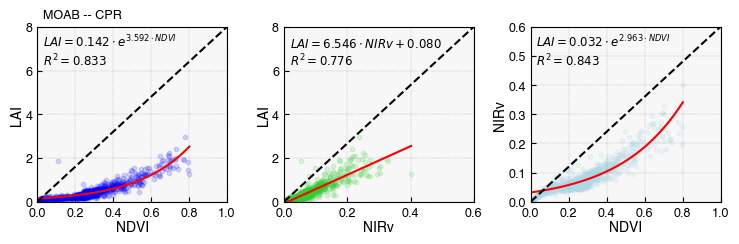

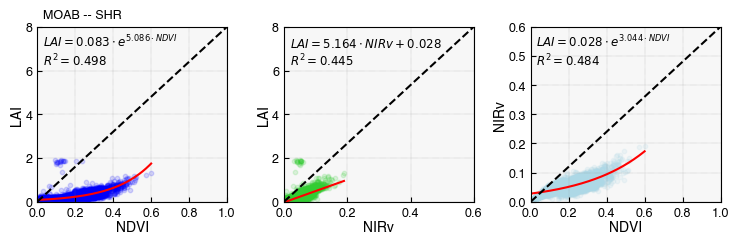

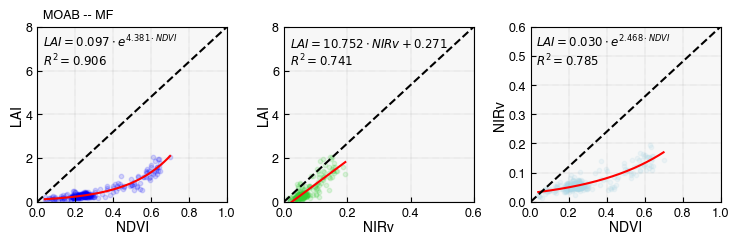

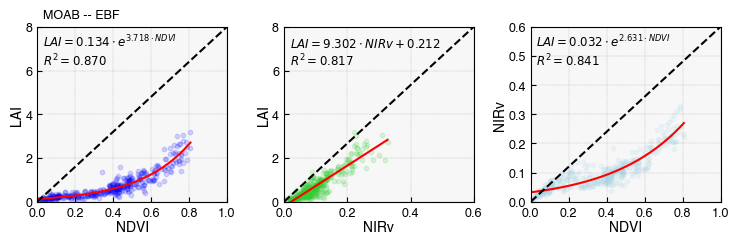

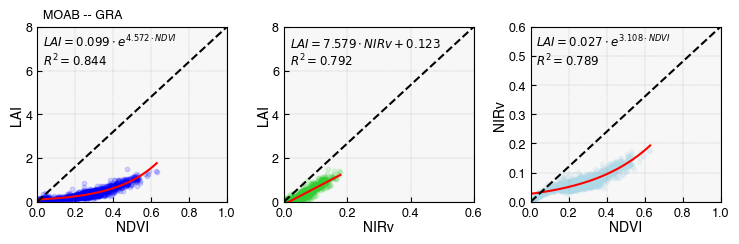

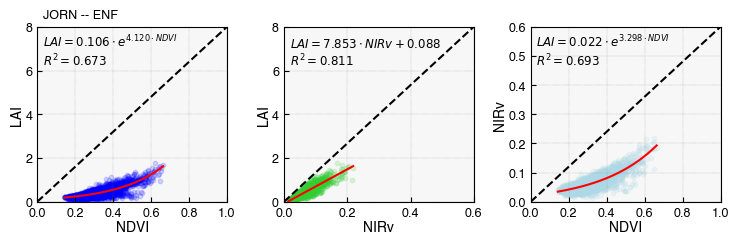

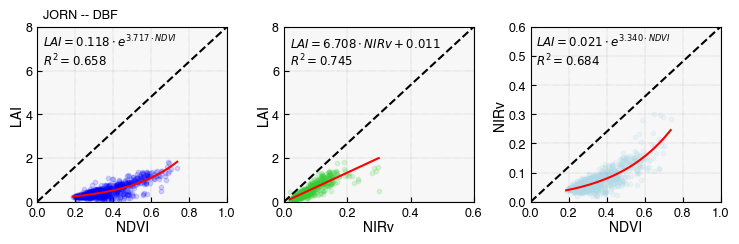

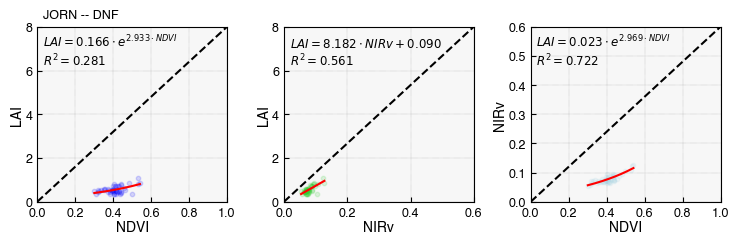

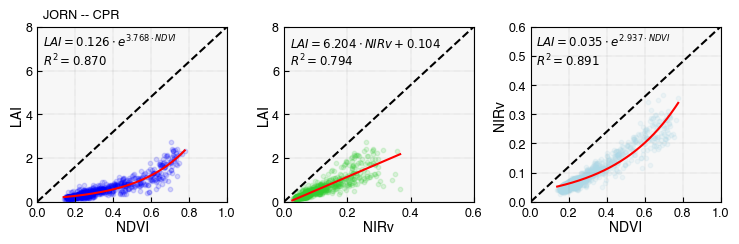

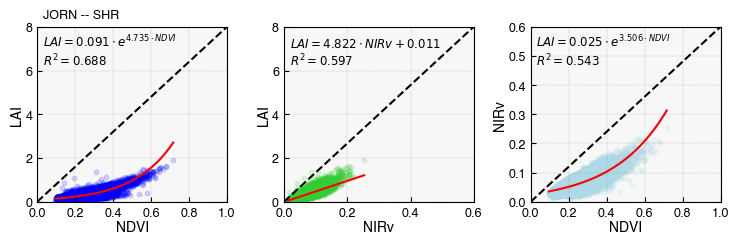

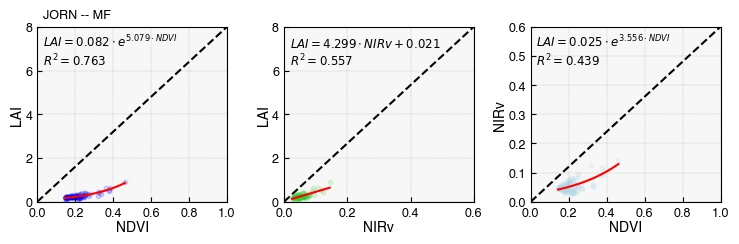

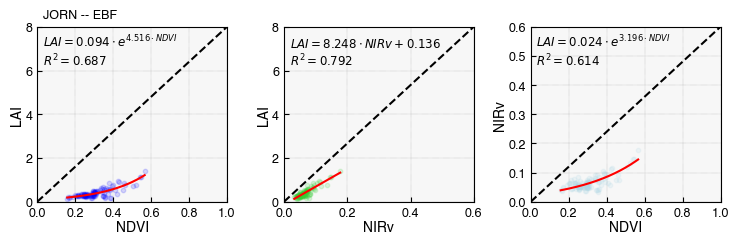

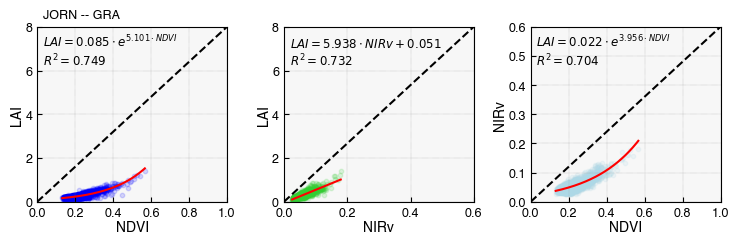

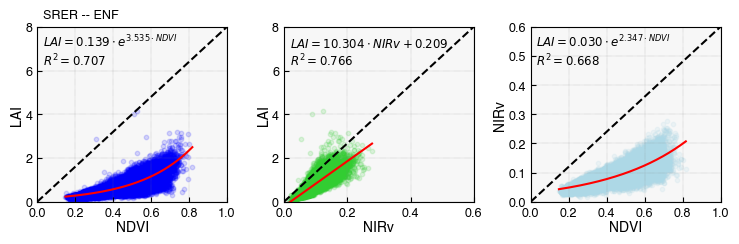

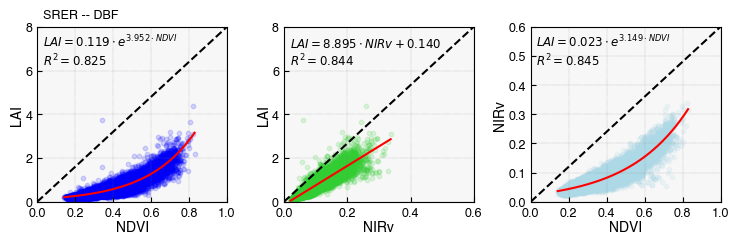

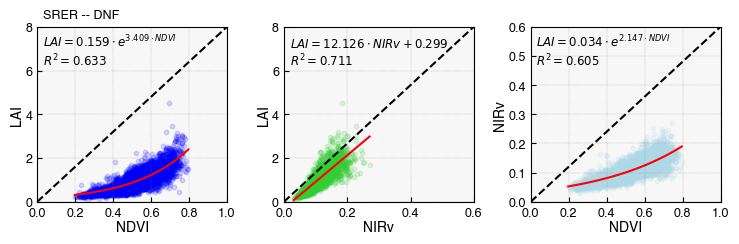

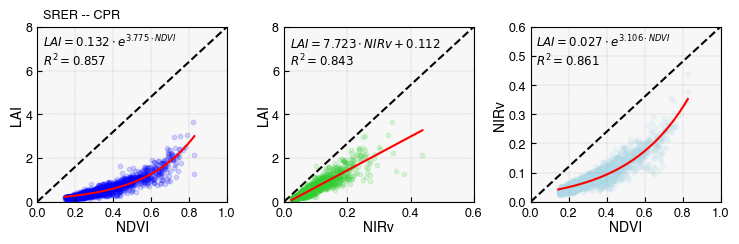

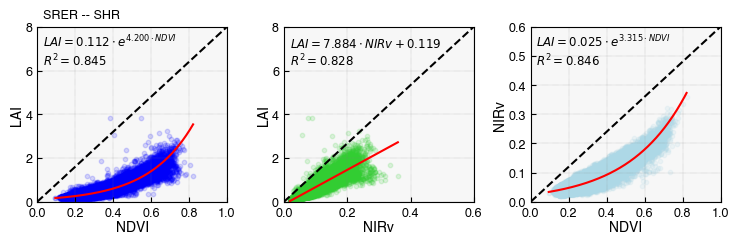

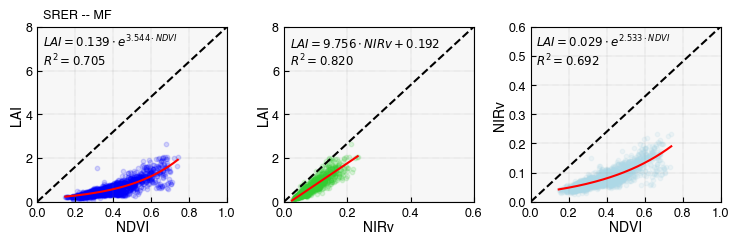

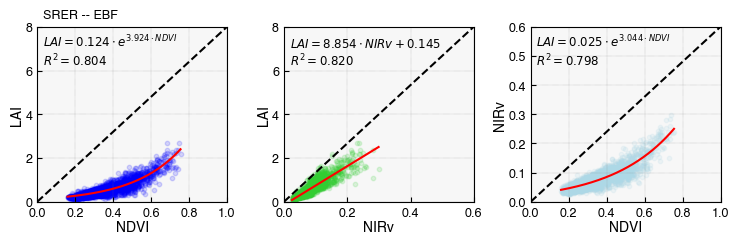

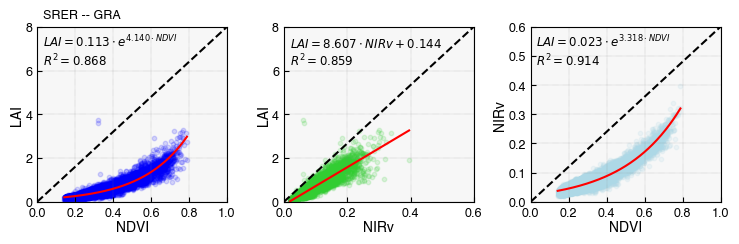

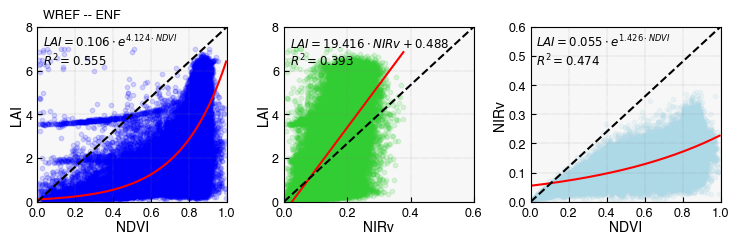

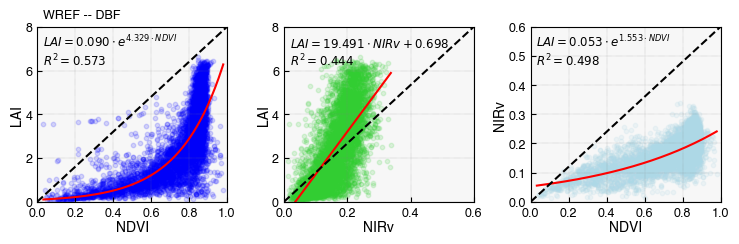

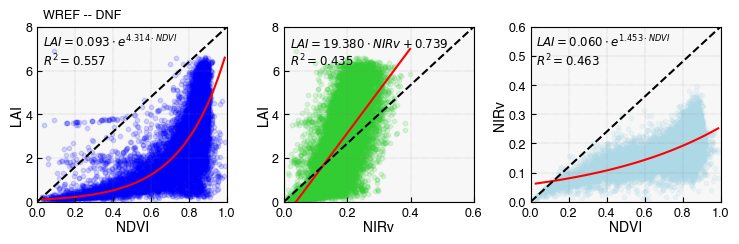

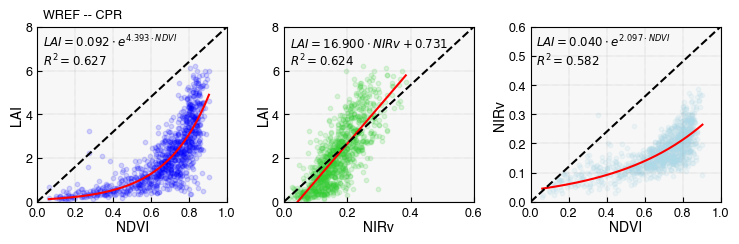

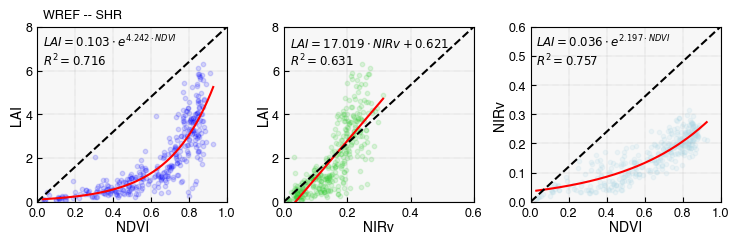

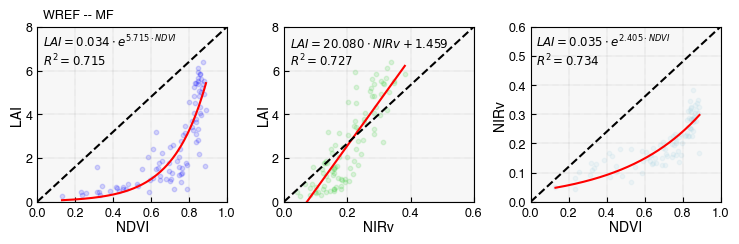

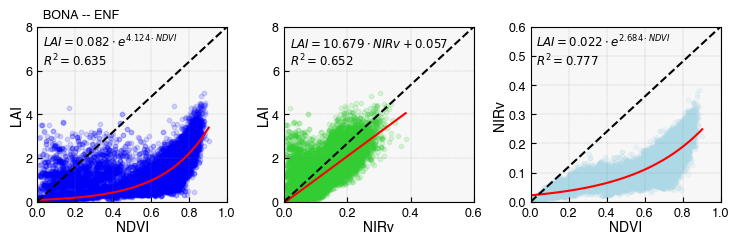

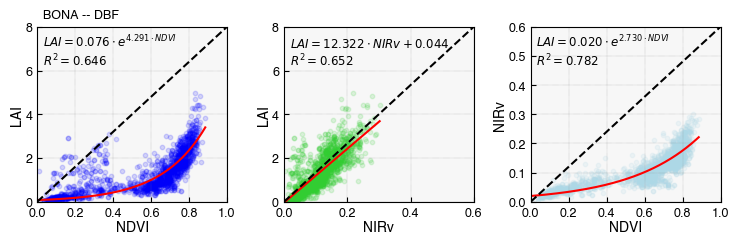

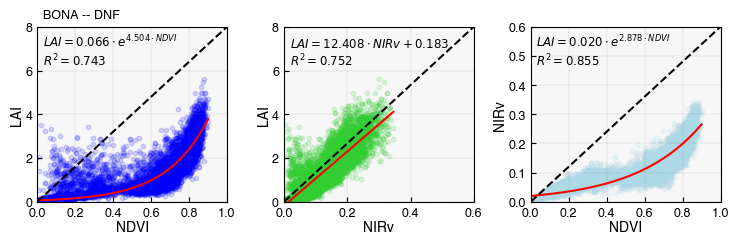

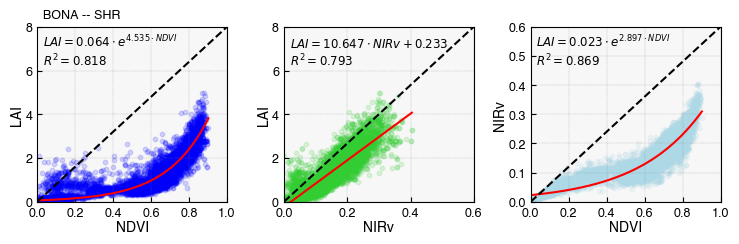

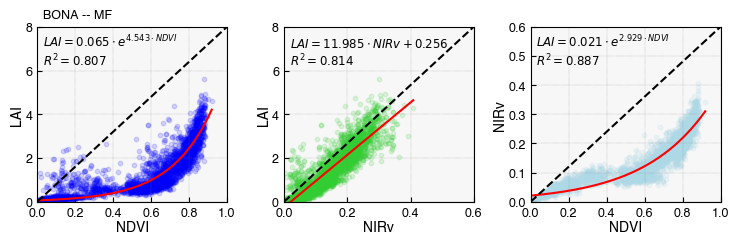

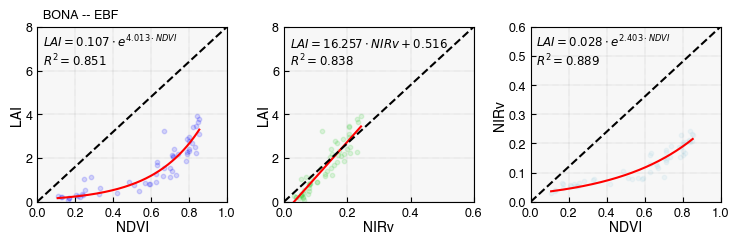

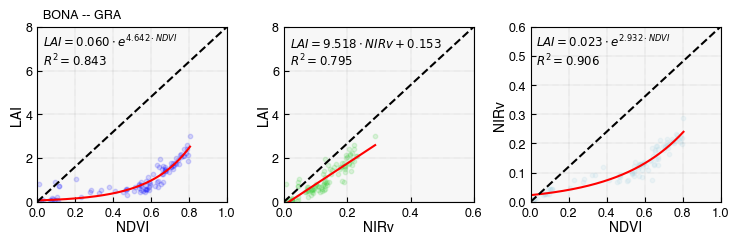

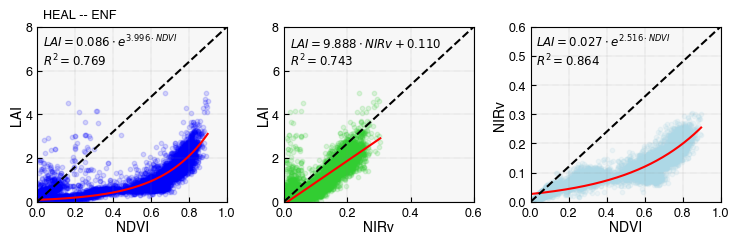

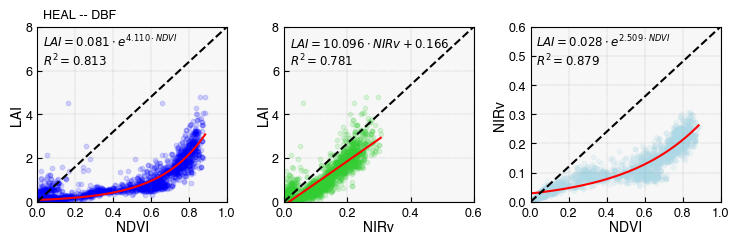

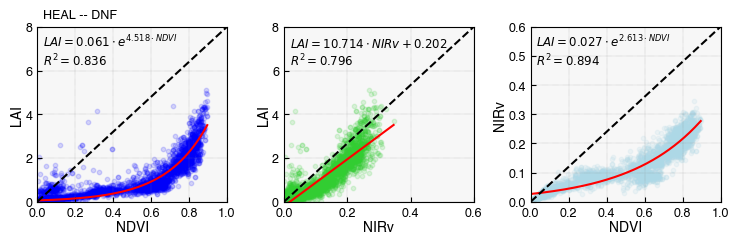

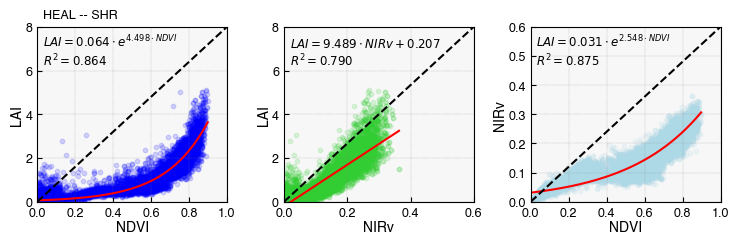

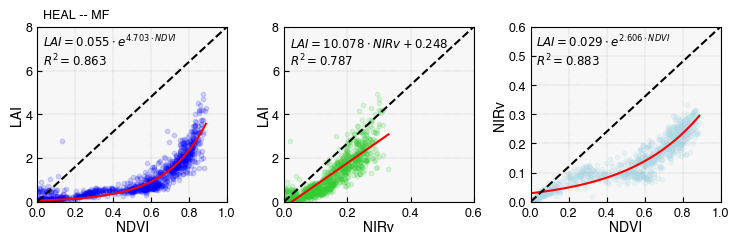

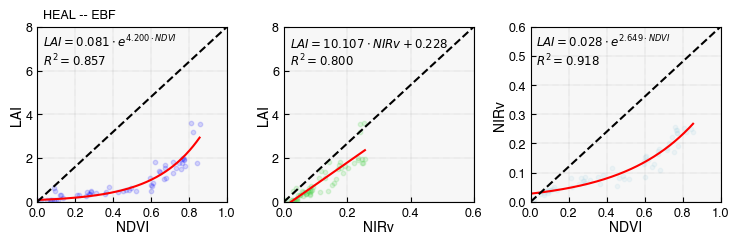

In [165]:
## site- and PFT-specific LAI models.
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"
all_df = pd.read_csv(f"{data_path}1_data_points_NDVI_NIRv_LAI.csv")
colors = [ "blue", "#32CD32","lightblue"]
for site in all_df["site"].unique():
    for pft in all_df["PFT"].unique():
        temp = all_df[(all_df["site"] == site)&(all_df["PFT"] == pft)]
        if len(temp)>10:
            fig = plt.figure(figsize = (12,5))
            config = {"font.family":'Helvetica'}
            plt.subplots_adjust(wspace =0.3, hspace =0.2)
            plt.rcParams.update(config)
            for kk in range(3):
                ax = fig.add_subplot(2,4,kk+1)
                ax.set_facecolor((0,0,0,0.03))
                ax.grid(color='gray', linestyle=':', linewidth=0.3)
                if kk ==0:
                    v1,v2 = "NDVI","LAI"
                    ax.set_xlim(0,1)
                    ax.set_ylim(0,8)
                    x,y = temp[v1],temp[v2]
                    params, covariance = curve_fit(exponential_model, x, y)
                    a, b = params
                    y_pred = exponential_model(x, a, b)
                    r_squared = round(r2(y, y_pred),3)
                    
                    x_fit = np.linspace(min(x), max(x), 200)
                    y_fit = exponential_model(x_fit, a, b)
                    
                    equation_text = f"$LAI = {a:.3f} \cdot e^{{{b:.3f} \cdot NDVI}}$\n$R^2 = {r_squared:.3f}$"
                    
                elif kk ==1:
                    v1,v2 = "NIRv","LAI"
                    ax.set_xlim(0,0.6)
                    ax.set_ylim(0,8)
                    x,y = temp[v1],temp[v2]
                    a, b, _, _, _ = stats.linregress(x, y)
                    r_squared = round(rsquared(x, y),3)
                    
                    x_fit = np.linspace(min(x), max(x), 200)
                    y_fit = a*x_fit+b
                    equation_text = f"${v2} = {a:.3f} \cdot {v1} + {b:.3f}$\n$R^2 = {r_squared:.3f}$" if b>0 else f"${v2} = {a:.3f} \cdot {v1} + {-b:.3f}$\n$R^2 = {r_squared:.3f}$"
                    
                else:
                    v1,v2 = "NDVI", "NIRv"
                    ax.set_xlim(0,1)
                    ax.set_ylim(0,0.6)
                    x,y = temp[v1],temp[v2]
                    params, covariance = curve_fit(exponential_model, x, y)
                    a, b = params
                    y_pred = exponential_model(x, a, b)
                    r_squared = round(r2(y, y_pred),3)
                    
                    x_fit = np.linspace(min(x), max(x), 200)
                    y_fit = exponential_model(x_fit, a, b)
                    equation_text = f"$LAI = {a:.3f} \cdot e^{{{b:.3f} \cdot NDVI}}$\n$R^2 = {r_squared:.3f}$"
        
        
                scatter = ax.scatter(x,y,color = colors[kk], alpha = 0.15,s = 10)
                ax.plot(x_fit, y_fit, color = "red", lw = 1.5)
                
                ax.set_xlabel(v1, fontsize=10, labelpad = 1)   
                ax.set_ylabel(v2, fontsize=10, labelpad = 1)     
                ax.tick_params(labelsize=9,direction='in')
                ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', lw = 1.5)
                ax.text(0.03, 1.05,f"{site} -- {pft}", fontsize=9,transform=ax.transAxes) if kk ==0 else None        
                ax.text(0.03, 0.78,equation_text, fontsize=8.5,transform=ax.transAxes)

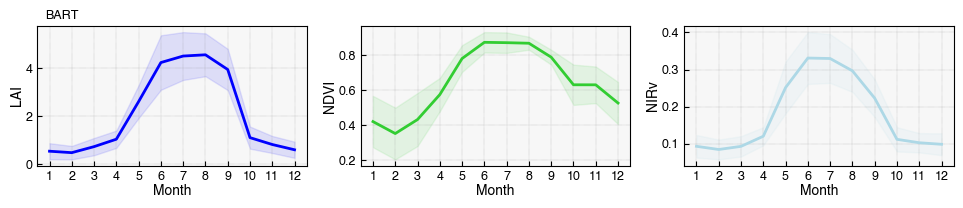

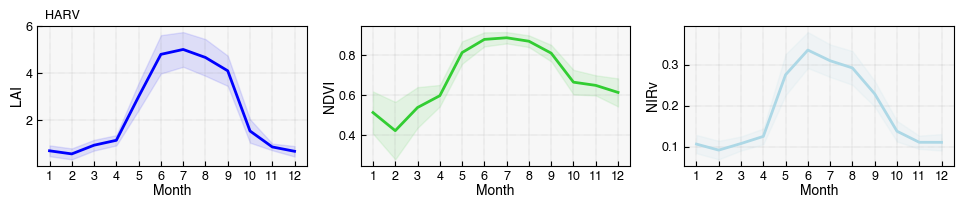

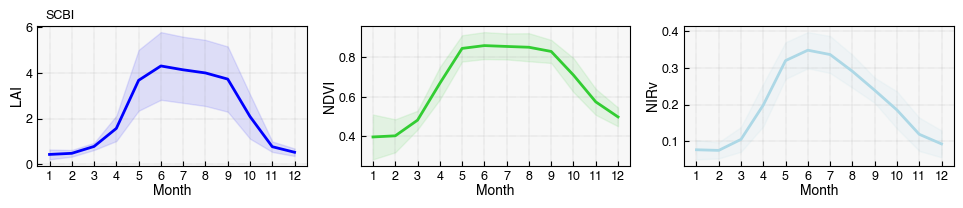

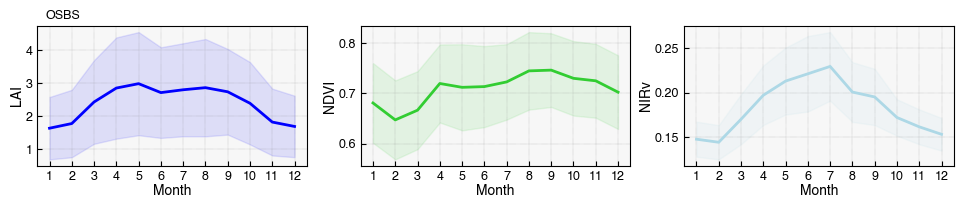

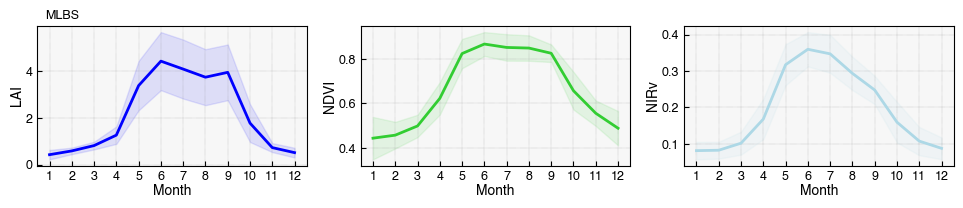

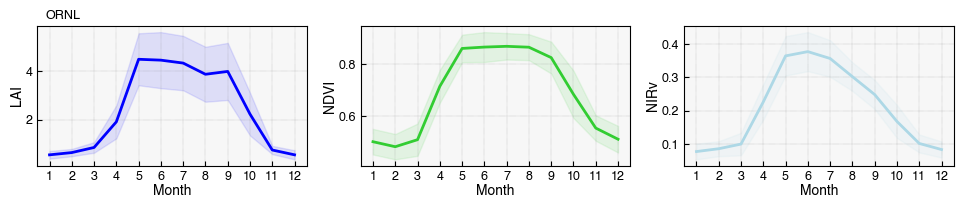

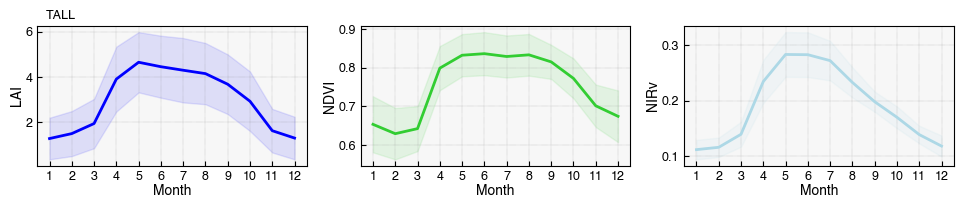

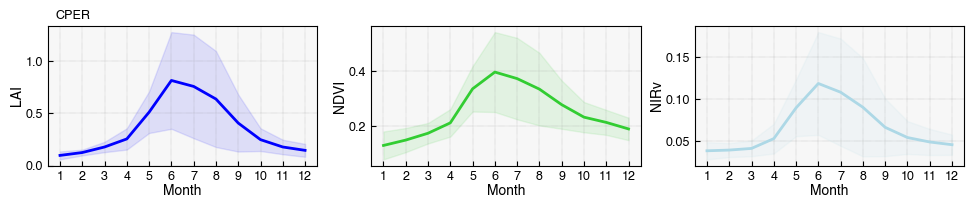

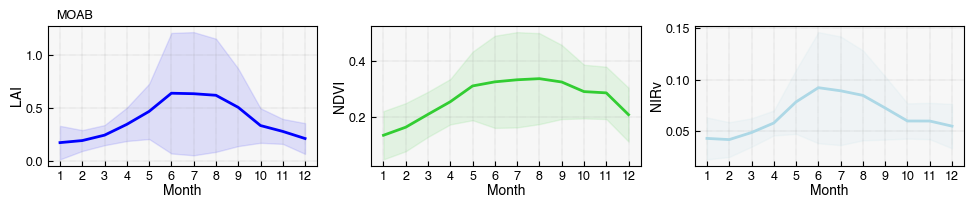

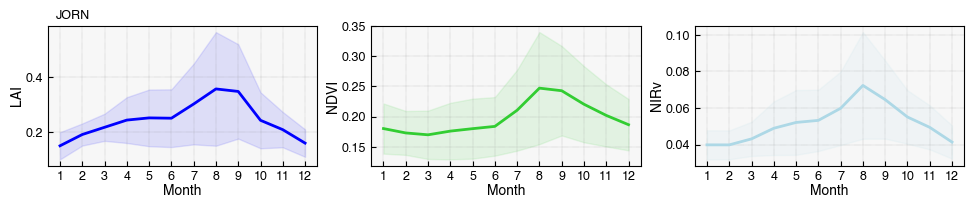

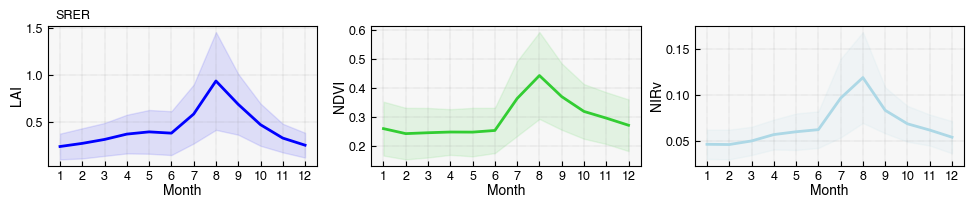

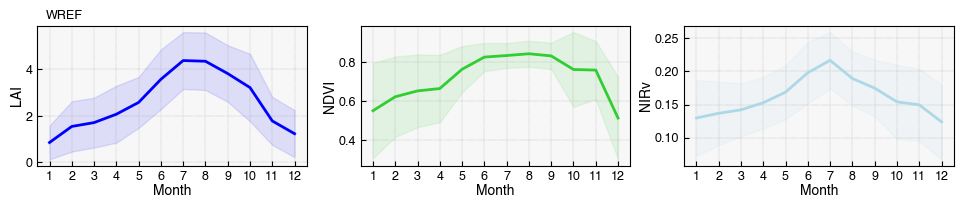

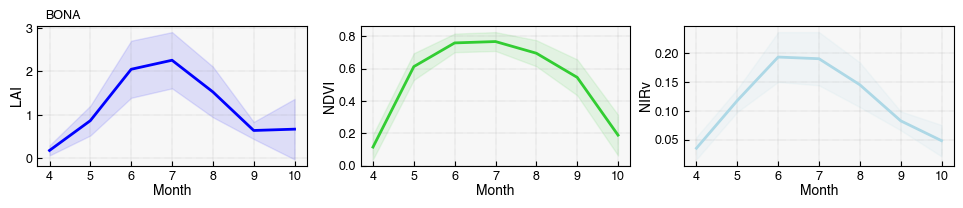

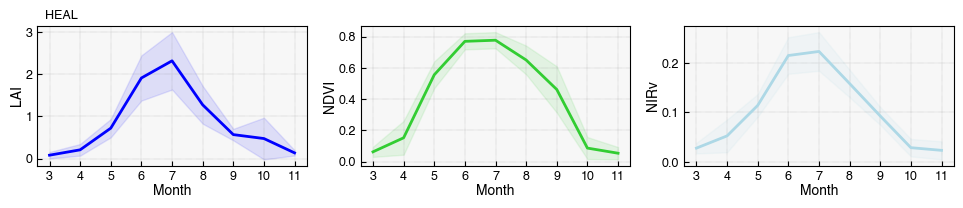

In [166]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"
all_df = pd.read_csv(f"{data_path}1_data_points_NDVI_NIRv_LAI.csv")

for site in all_df["site"].unique():
    temp = all_df[all_df["site"] == site]
    if (site == "BONA")|(site == "HEAL"):
        temp = temp[~temp['month'].isin([1, 2])]
    temp = temp[["NIRv","NDVI", "LAI","month"]]
    
    mean = temp.groupby("month").mean()
    std  = temp.groupby("month").std()
    
    fig = plt.figure(figsize = (16,4))
    config = {"font.family":'Helvetica'}
    plt.subplots_adjust(wspace =0.2, hspace =0.2)
    plt.rcParams.update(config)
    
    variables = ["LAI","NDVI","NIRv"]
    for kk in range(3):
        ax = fig.add_subplot(2,4,kk+1)
        ax.set_facecolor((0,0,0,0.03))
        ax.grid(color='gray', linestyle=':', linewidth=0.3)
        
        x,y = mean.index, mean[variables[kk]]
        x = x.astype(str)
        lc,hc = y-std[variables[kk]], y+std[variables[kk]]
        ax.plot(x,y, markersize = 6,linewidth=2, color = colors[kk])
        ax.fill_between(x, lc,hc, alpha=0.1, color = colors[kk])
        
        ax.set_xlabel("Month", fontsize=10, labelpad = 1)   
        ax.set_ylabel(variables[kk], fontsize=10, labelpad = 1)     
        ax.tick_params(labelsize=9,direction='in')
        ax.text(0.03, 1.05,f"{site}", fontsize=9,transform=ax.transAxes) if kk ==0 else None 

### 11. export models

In [183]:
data_path = "/Volumes/ChenLab/Fujiang/0_PhD_dissertation_data/12_RTM_estimation_through_given_LAI/1_LAI_estimation/1_original_data/8_extract_VI_LAI_to_points/"
all_df = pd.read_csv(f"{data_path}1_data_points_NDVI_NIRv_LAI.csv")

start = True
for site in all_df["site"].unique():
    temp = all_df[all_df["site"] == site]
    variables = ["NDVI","NIRv"]
    for var in variables:
        x,y = temp[var],temp["LAI"]
        if var == "NDVI":
            params, covariance = curve_fit(exponential_model, x, y)
            a, b = params
            y_pred = exponential_model(x, a, b)
            r_squared = round(r2(y, y_pred),3)
        else:
            a, b, _, _, _ = stats.linregress(x, y)
            r_squared = round(rsquared(x, y),3)
        array = pd.DataFrame([var,a,b,"all",r_squared, site]).T
        array.columns = ["x", "a", "b", "PFT", "R2", "site"]
        if start:
            df1 = array
            start = False
        else:
            df1 = pd.concat([df1, array], axis = 0)     

start = True
for site in all_df["site"].unique():
    for pft in all_df["PFT"].unique():
        temp = all_df[(all_df["site"] == site)&(all_df["PFT"] == pft)]
        variables = ["NDVI","NIRv"]
        if len(temp)>10:
            for var in variables:
                x,y = temp[var],temp["LAI"]
                if var == "NDVI":
                    params, covariance = curve_fit(exponential_model, x, y)
                    a, b = params
                    y_pred = exponential_model(x, a, b)
                    r_squared = round(r2(y, y_pred),3)
                else:
                    a, b, _, _, _ = stats.linregress(x, y)
                    r_squared = round(rsquared(x, y),3)
                    
                array = pd.DataFrame([var,a,b,pft,r_squared, site]).T
                array.columns = ["x", "a", "b", "PFT", "R2", "site"]
                if start:
                    df2 = array
                    start = False
                else:
                    df2 = pd.concat([df2, array], axis = 0)

df = pd.concat([df1, df2], axis = 0)
df.reset_index(drop =True, inplace = True)
df.to_csv(f"{data_path}2_saved_models.csv", index = False)